In [1]:
import os
os.chdir("..")
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import lognorm
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy.optimize import minimize

In [2]:
with open("data/scenario_san_francisco.json") as f:
    data = json.loads(f.read())

In [3]:
df = pd.DataFrame(data["demand"])

# Simple summary stats

In [4]:
df_org_dest = df.groupby(["origin", "destination"]).agg({"price": ["count", "mean"], "demand": "mean", "travel_time":"mean"}).reset_index()

In [5]:
df_org_dest.head()

origin destination price           demand travel_time
                     count   mean      mean        mean
0      0           2    15  10.00  0.066667         4.0
1      0           8    15  46.40  0.066667        31.0
2      1           5    15  16.50  0.133333        10.0
3      1           7    30  31.95  0.066667        18.5
4      2           0    15  10.50  0.066667         5.0

In [32]:
df.groupby("travel_time").agg({"price": ["mean","std"]})

price          
                  mean       std
travel_time                     
3            10.000000  0.000000
4            10.000000  0.000000
5            10.328571  0.454828
6            10.536842  0.772692
7            11.350000  0.790872
8            12.346875  1.096298
9            13.802439  1.731696
10           14.950000  2.005243
11           15.780556  1.825274
12           18.065385  2.589073
13           20.907692  2.638082
14           22.188889  3.026627
15           23.152381  2.794151
16           25.745455  3.559519
17           27.573684  2.521913
18           26.933333  3.532894
19           31.762500  3.123886
20           33.000000  6.065032
21           32.766667  0.985117
22           34.525000  4.387217
23           35.500000  2.949576
24           31.900000  1.627352
25           39.400000  0.000000
27           40.700000  3.559833
28           46.400000  0.000000
31           44.600000  1.830771
33           55.000000  0.000000
55           69.400000  0.000000

In [6]:
df_org_dest.columns = df_org_dest.columns.droplevel(0)
df_org_dest.columns = ["Origin", "Destination", "count", "mean_price", "mean_demand", "mean_travel_time"]

In [7]:
df.describe()

,time_stamp,origin,destination,demand,travel_time,price
count,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000,5370.000000
mean,1230.296089,6.237430,5.737430,0.385661,11.977654,18.692179
std,51.039938,2.014673,2.372853,0.496670,5.371075,8.274623
min,1140.000000,0.000000,0.000000,0.066667,3.000000,10.000000
25%,1186.000000,5.000000,4.000000,0.066667,9.000000,12.800000
50%,1232.000000,7.000000,6.000000,0.133333,11.000000,15.700000
75%,1273.000000,8.000000,8.000000,0.466667,15.000000,22.700000
max,1319.000000,9.000000,9.000000,2.333333,55.000000,69.400000


In [8]:
print(f"Origin nodes: {np.sort(df.origin.unique())}")
print(f"Destination nodes: {np.sort(df.destination.unique())}")

Origin nodes: [0 1 2 3 4 5 6 7 8 9]
Destination nodes: [0 1 2 3 4 5 6 7 8 9]


# Grid analysis

In [9]:
pivot_df = df_org_dest.pivot(index='Origin', columns='Destination', values='count').T
pivot_df = pivot_df

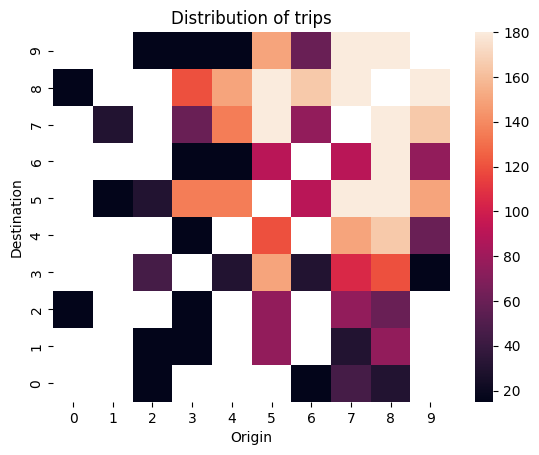

In [10]:
sns.heatmap(pivot_df.iloc[::-1], annot=False, fmt="d")
plt.title('Distribution of trips')
plt.xlabel(pivot_df.columns.name)
plt.ylabel(pivot_df.index.name)
plt.show()

In [11]:
mean_demand_matrix = df.groupby("origin")["demand"].mean().values.reshape(1,pivot_df.shape[1])

In [12]:
mean_demand_matrix

array([[0.06666667, 0.08888889, 0.06666667, 0.07948718, 0.12291667,
        0.39411765, 0.12413793, 0.36811594, 0.75641026, 0.37984496]])

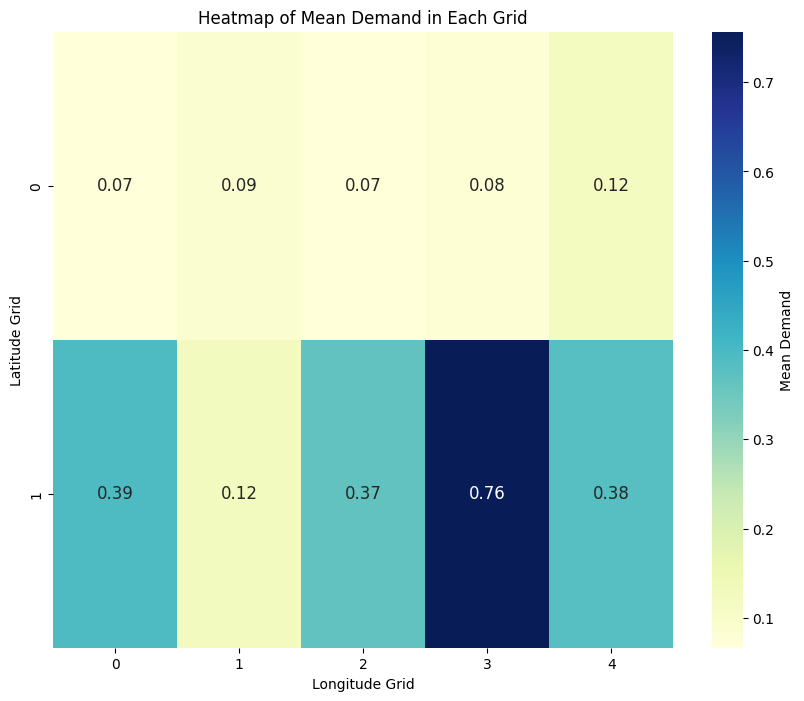

In [13]:
plt.figure(figsize=(10, 8))
sns.heatmap(mean_demand_matrix.reshape(2,5), annot=True, fmt=".2f", cmap="YlGnBu", cbar_kws={'label': 'Mean Demand'}, annot_kws={"size": 12})
plt.title('Heatmap of Mean Demand in Each Grid')
plt.xlabel('Longitude Grid')
plt.ylabel('Latitude Grid')
plt.show()

# Travel time analysis

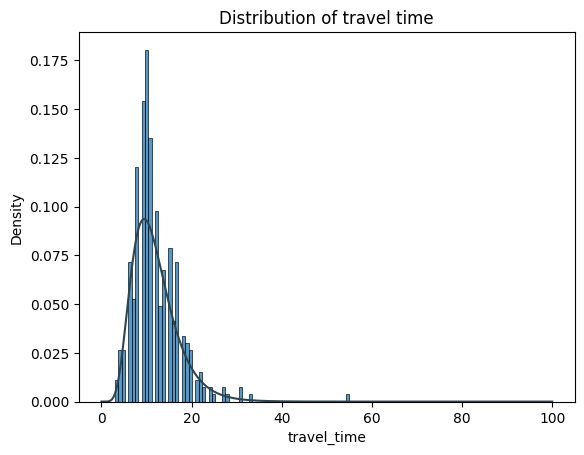

In [14]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["travel_time"])
sns.histplot(df["travel_time"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of travel time")
plt.show()

# Price analysis

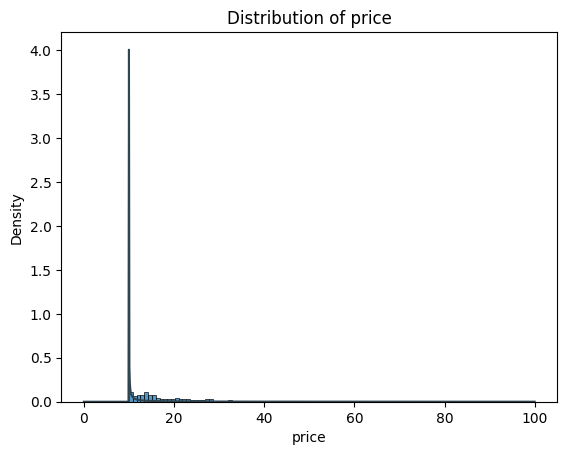

In [15]:
x = np.linspace(0, 100, 1000)
fitted_params = lognorm.fit(df["price"])
sns.histplot(df["price"], bins=70, stat="density")
plt.plot(x, lognorm(*fitted_params).pdf(x), color="#2F4550")
plt.title("Distribution of price")
plt.show()

In [16]:
pred_df = df.copy()

In [17]:
pred_df["poly_travel_time"] = pred_df["travel_time"]**2
pred_df["poly_demand"] = pred_df["demand"]**2
pred_df["log_price"] = np.log(pred_df["price"])

In [28]:
glm_model = smf.glm(formula="price ~ travel_time", data=pred_df, family=sm.families.Gaussian())

In [29]:
fitted_glm = glm_model.fit()

In [30]:
fitted_glm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                 5370
Model:                            GLM   Df Residuals:                     5368
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                          7.4242
Method:                          IRLS   Log-Likelihood:                -13001.
Date:                Tue, 05 Dec 2023   Deviance:                       39853.
Time:                        09:30:22   Pearson chi2:                 3.99e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9997
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       1.2684      0.091     13.957      0.000       1.090       1.447
travel_time     1.4547      0.007    210.113      0.000       1.441       1.468
===============================================================================
"""

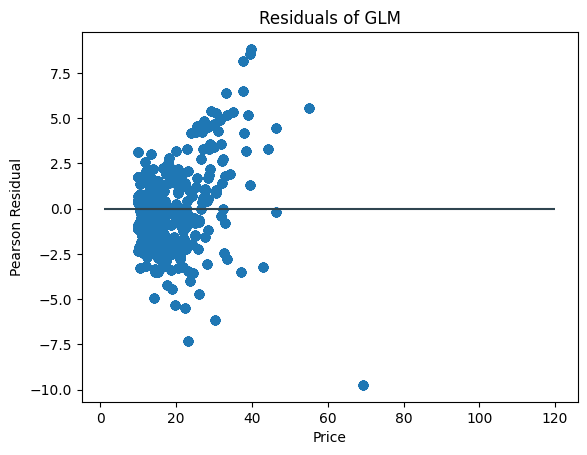

In [21]:
plt.scatter(pred_df["price"], pred_df["price"] - fitted_glm.predict())
plt.hlines(y=0, xmin=1, xmax=120, color="#2F4550")
plt.xlabel("Price")
plt.ylabel("Pearson Residual")
plt.title("Residuals of GLM")
plt.show()

# Predicting demand

In [22]:
def model_2(vars, price):
    alpha, beta = vars
    demand_hat = np.exp(alpha + beta * price)
    return demand_hat

In [23]:
def mse_model2(vars, price, demand):
    demand_hat = model_2(vars, price)
    return np.mean((demand-demand_hat)**2)

In [24]:
x0 = (5,-0.6)
res = minimize(mse_model2, x0, args=(df.price, df.demand), tol=1e-3, method="Powell")

In [25]:
res

 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.2234310895420389
       x: [ 6.812e-02 -5.828e-02]
     nit: 6
   direc: [[-3.076e+00  3.588e-01]
           [-3.967e-01  2.684e-02]]
    nfev: 154

In [26]:
res.x

array([ 0.06811853, -0.05827745])

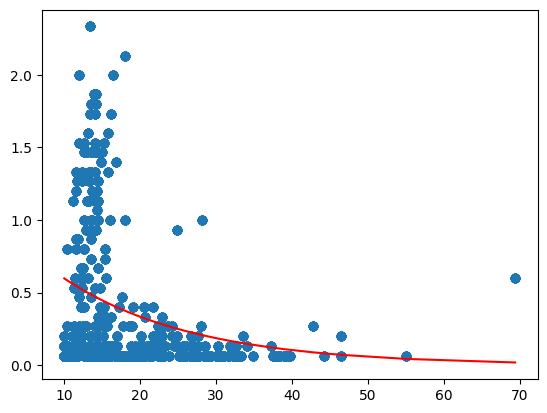

In [27]:
plt.plot(df.price.sort_values(ascending=False).values, model_2(res.x, df.price.sort_values(ascending=False).values), color="red")
plt.scatter(df.price.sort_values(ascending=False).values,df.sort_values("price", ascending=False).demand.values)